# DAC Contest
This reference design will help you walk through a design flow of DAC SDC 2022. This is a simplified design to help users get started on the FPGA platform and to understand the overall flow. It does not contain any object detection hardware.

If you have any questions, please post on the [Piazza page](piazza.com/dac_2018/summer2022/dacsdc2022).

### Hardware
The base hardware design contains the Zynq MPSoC processor (A53) with a DMA and FIFO implemented in the PL.
Note that in this starting hardware, no actual image processing/detection is done. Pictures are:
  * Sent from PS to DMA, then DMA to FIFO
  * Sent back from FIFO to DMA, then DMA to PS.

Note that the FIFO should be replaced with meaningful hardware to process the pictures.

You can create a Vivado project by opening Vivado 2019.1, changing to the hw directory, and running `source dac_sdc.tcl`. This will create and open a project that you can edit.  On the final submission you are required to submit the sources files of your design, and you should run `File->Project->Write Tcl...` to generate a new tcl file to submit. Be sure to check the `Recreate Block Designs using Tcl` box, and include any custom IP modules you use.

### Software
Note:
  * You will not submit your `dac_sdc.py` file, so any changes you make to this file will not be considered during evluation.  
  * You can use both PS and PL side to do inference.

### Object Detection

Object detection will be done on images in batches:
  * You will provide a Python callback function that will perform object detection on batch of images.  This callback function wile be called many times.
  * The callback function should return the locations of all images in the batch.
  * Runtime and energy usage will be recorded during your callback function.
  * Images will be loaded from SD card before each batch is run, and this does not count toward your energy usage or runtime.
  
### Notebook
Your notebook should contain 4 code cells:

1. Importing all libraries and creating your Team object.
1. Downloading the overlay, and performany any one-time configuration.
1. Python callback function and any other Python helper functions.
1. Running object detection
1. Cleanup



## 1. Imports and Create Team

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../common"))

import math
import time
import numpy as np
from PIL import Image
from matplotlib import pyplot
import cv2
from datetime import datetime

import pynq
import dac_sdc
from IPython.display import display

team_name = 'sample_team'
team = dac_sdc.Team(team_name)

**Your team directory where you can access your bitstream, notebook, and any other files you submit, is available as `team.team_dir`.**

## 2. Preparing the overlay/bitstream and weight loading
Overlay/bitstream loading must be executed in this cell.

In this sample hardware, the DMA instance is exposed as an attribute of the overlay object.  You aren't required to use DMA for your hardware solution.

In [2]:
overlay = pynq.Overlay(team.get_bitstream_path())
dma = overlay.axi_dma_0

## 3. Python Callback Function and Helper Functions


### Pushing the picture through the pipeline
In this example, we use contiguous memory arrays for sending and receiving data via DMA.

The size of the buffer depends on the size of the input or output data.  The example images are 640x360 (same size as training and test data), and we will use `pynq.allocate` to allocate contiguous memory.

### Callback function
The callback function:
  - Will be called on each batch of images (will be called many times)
  - Is prvided with a list of tuples of (image path, RGB image)
  - It should return a list of object locations, where each location is a tuple (xmin, xmax, ymin, ymax) indicating the bounding box. This list should have the same number of elements as images provided to you. The first element in the list will correspond to the first image in the rgb_imgs list, etc.


In [3]:
in_buffer = pynq.allocate(shape=(360, 640, 3), dtype=np.uint8, cacheable = 1)
out_buffer = pynq.allocate(shape=(360, 640, 3), dtype=np.uint8, cacheable = 1)

def dma_transfer():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    
def my_callback(rgb_imgs):
    img_locations = []
    for (img_path, img) in rgb_imgs:
        print("Loading image", img_path, "into buffer for DMA transfer")
        in_buffer[:] = img    
        dma_transfer()
        print("\tDMA transfer complete")
        
        # Show image (notebook will only show latest image)
        pyplot.imshow(out_buffer)
        
        # Appending fake image location, since this example doesn't actually perform object detection 
        img_locations.append([50,90,70,130])
        
    return img_locations

## 4. Running Object Detection

Call the following function to run the object detection.  Extra debug output is enabled when `debug` is `True`.

Batch 1 starting. 2 images.
Loading image /home/xilinx/jupyter_notebooks/dac_sdc_2022/images/0.jpg into buffer for DMA transfer
	DMA transfer complete
Loading image /home/xilinx/jupyter_notebooks/dac_sdc_2022/images/1.jpg into buffer for DMA transfer
	DMA transfer complete
Batch 1 done. Runtime = 1.9738342761993408 seconds. Energy = 2.9607514142990112 J.
Done all batches. Total runtime = 1.9738342761993408 seconds. Total energy = 2.9607514142990112 J.
Savings results to XML...
XML results written successfully.


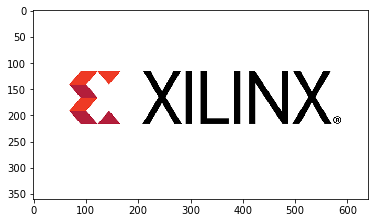

In [4]:
team.run(my_callback, debug=True)

## 5. Cleanup

In [5]:
# Remember to free the contiguous memory after usage.
del in_buffer
del out_buffer